In [1]:
import pandas as pd
import glob
import json
import seaborn as sns
import tarfile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# decompress 'data.tar'gz'

# with tarfile.open("data_finalized.tar.gz", "r:gz") as tar:
#     tar.extractall()

paths = glob.glob('data_finalized/**/paths.json', recursive=True)
properties = glob.glob('data_finalized/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

# remove data folder

# shutil.rmtree('data')

In [3]:
df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

print(f'There are {df.query("pairable & min_permanent < 0").shape[0] / df.query("pairable").shape[0]:.1%} of pairable paths with negative permanents!')

There are 51.5% of pairable paths with negative permanents!


[Text(0.5, 0, 'Number of pairable paths'), Text(0, 0.5, 'Conductance')]

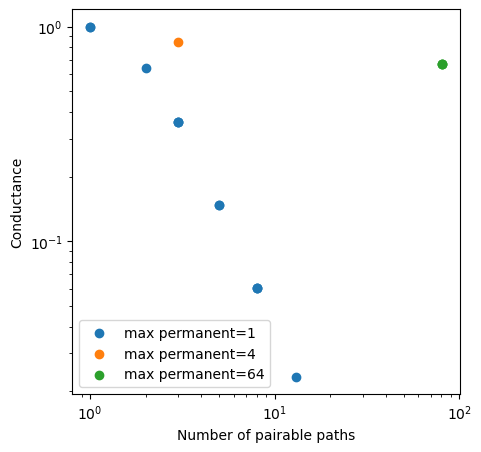

In [4]:
def f(x, a, b):
    # c = 1 - a
    # return a * np.exp(-b * x) + (1 - a)
    return a * x**(-b)

fig, ax = plt.subplots(figsize=(5, 5))
for max_permanent in [1, 4, 16, 64]:
    df_temp = df.query("max_permanent == @max_permanent & min_permanent >= 0")
    x = df_temp["pairablepath_count"].values
    y = df_temp["conductance"].values
    if len(df_temp) == 0:
        continue
    ax.scatter(x, y, label=f"max permanent={max_permanent}")
    if len(df_temp) > 1:
        popt, pcov = curve_fit(f, x, y)
        X = np.linspace(x.min(), x.max(), 100)
        Y = f(X, *popt)
        # ax.plot(X, Y, label=f"$y={popt[0]:.2f}\\exp(-{popt[1]:.2f}x)$")
    
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set(xlabel='Number of pairable paths', ylabel='Conductance')